Index(['x1', 'y1', 'MFC6', 'MFC7', 'MFC8', 'MFC9', 'MFC10', 'MFC1', 'MFC2',
       'MFC3', 'MFC4', 'MFC5'],
      dtype='object')
(359, 12)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 352)               11616     
                                                                 
 dense_3 (Dense)             (None, 192)               67776     
                                                                 
 dense_4 (Dense)             (None, 96)              

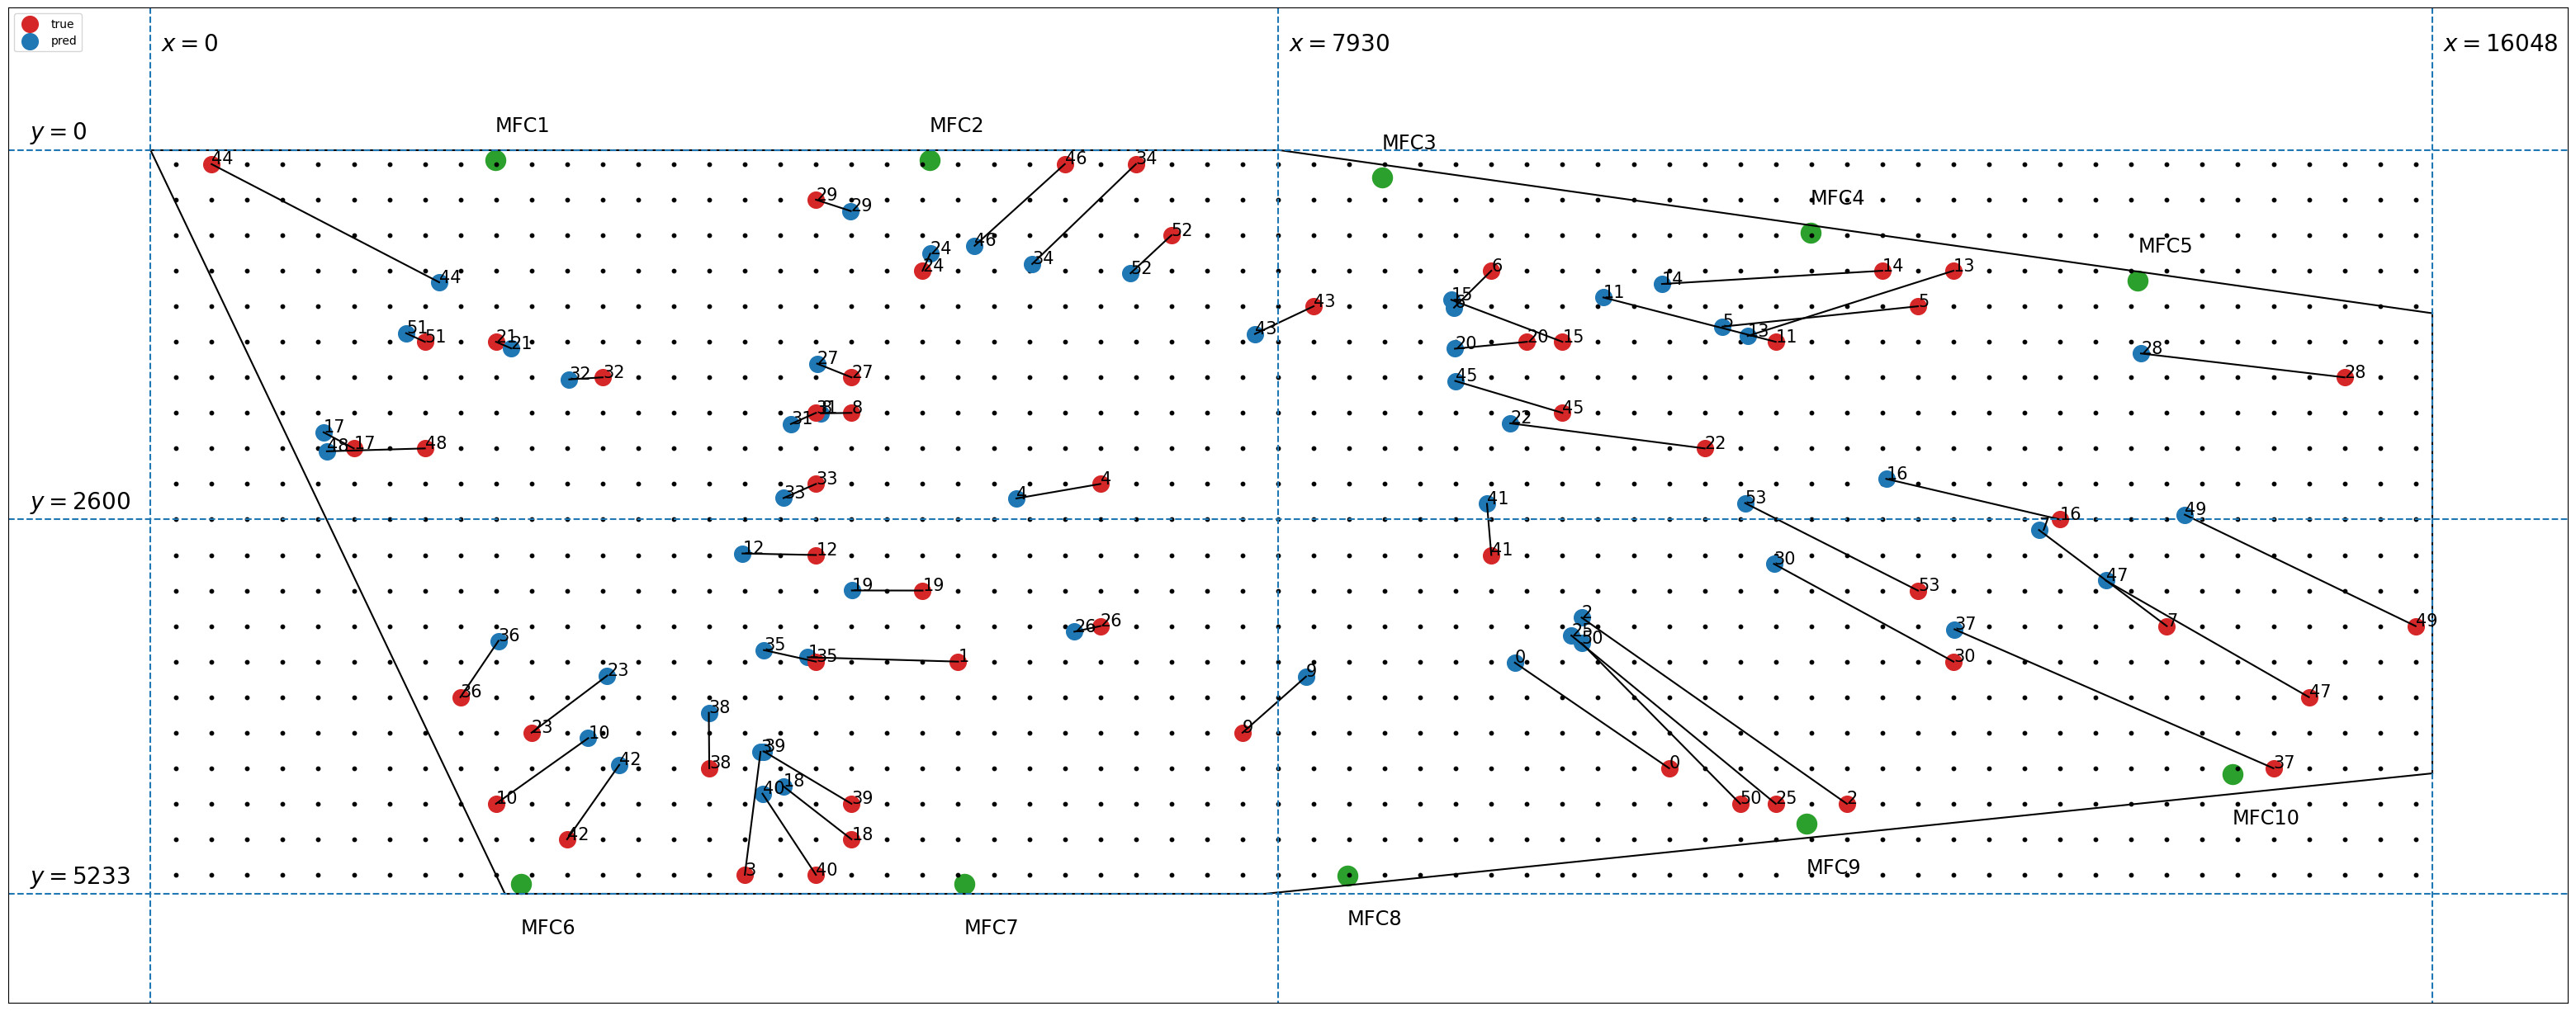

[[2815.022 1150.594]
 [2876.523  883.917]
 [3418.869 1244.154]
 [2909.499 1081.229]
 [2364.601  750.002]
 [3298.084 1148.892]
 [2673.11   941.353]
 [3136.045 1206.761]
 [2529.236  829.066]
 [2631.947  884.347]
 [3408.133 1126.123]
 [3285.742 1040.095]
 [2670.213  855.459]
 [3239.348 1140.312]
 [3560.155 1184.149]
 [2811.3    867.026]
 [3523.023  909.463]
 [3236.732 1010.015]
 [3171.151 1154.67 ]
 [2589.876  899.729]
 [2537.764  850.129]
 [2950.858  951.704]
 [3311.755  829.89 ]
 [3064.865 1024.747]
 [2705.436 1011.131]
 [3309.02  1323.141]
 [2354.123  824.31 ]
 [2722.944  888.894]
 [3085.791 1079.594]
 [2829.642 1055.746]
 [3131.012 1084.773]
 [2500.544  822.515]
 [2939.544  901.733]
 [2567.807  828.014]
 [2784.716  986.945]
 [2898.518  914.317]
 [3184.539 1014.161]
 [3907.545 1436.077]
 [2945.914  995.727]
 [3081.109 1146.932]
 [3120.883 1149.125]
 [2654.121  836.266]
 [3440.039 1140.276]
 [2674.209  897.938]
 [3514.004 1064.727]
 [2720.945  809.683]
 [2574.769 1033.661]
 [3495.389 13

In [10]:
# %%
import tensorflow as tf
from utils.data_preprocess import load_data
from utils.module import model_eval
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from utils.model_evaluation import plot_test_pred

# Sandwiched dropout layer to the hyperparameter tuned model and did the predictions 1000 times without training the model again
# Sandwiched dropout layer to the hyperparameter tuned model and did the predictions 1000 times after training the model again
# During hyperparameter tuning, it is ensured that a dropout layer is there after a dense layer. This model is directly used for uncertainity quanitification

single_leakage, two_leakage = load_data()
# print(single_leakage.columns)
data = single_leakage.drop(columns=['total flow rate', 'mfc6_residual',
       'mfc7_residual', 'mfc8_residual', 'mfc9_residual', 'mfc10_residual',
       'mfc1_residual', 'mfc2_residual', 'mfc3_residual', 'mfc4_residual',
       'mfc5_residual'])

print(data.columns)
print(data.shape)

y = data[['x1', 'y1']]
x = data.drop(['x1', 'y1'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) 

scaler_coords = StandardScaler()
y_train = scaler_coords.fit_transform(y_train)
y_test = scaler_coords.transform(y_test)
y_val = scaler_coords.transform(y_val)

scaler_flows = StandardScaler()
X_train = scaler_flows.fit_transform(X_train)
X_test = scaler_flows.transform(X_test)
X_val = scaler_flows.transform(X_val)

# %%
dropout_prob = 0.1

model = tf.keras.models.load_model('saved_model/single_leak/single_leakage_model_less')
print(model.summary())
model_evaluate, y_pred = model_eval(model, X_test, y_test, X_train, y_train, X_val, y_val)

stoch_model = tf.keras.Sequential()

for i, layer in enumerate(model.layers):
    stoch_model.add(layer)
    # Add your intermediate layer after each existing layer
    if i == 0:
        continue
    if i == len(model.layers)-1:
        continue
    intermediate_layer = tf.keras.layers.Dropout(dropout_prob)
    stoch_model.add(intermediate_layer)

# Compile the new model
stoch_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=model.optimizer.lr.numpy()),
                loss="mse",
                metrics='mae')
# Print the summary of the new model
stoch_model.summary()
model_evaluate, y_pred = model_eval(stoch_model, X_test, y_test, X_train, y_train, X_val, y_val)
# # # %%
pred=np.stack([stoch_model(X_test,training=True) 
               for sample in range(1000)])
predictions_list = pred.tolist()
predictions_list_unsc = []
# print(len(predictions_list))
for pred in predictions_list:
    pred = scaler_coords.inverse_transform(pred)
    predictions_list_unsc.append(pred)
predictions__unsc = np.array(predictions_list_unsc)

# print(predictions__unsc.shape)
pred_mean=predictions__unsc.mean(axis=0)
pred_std = predictions__unsc.std(axis=0) 
# print(pred_mean.shape, pred_std.shape)
# # %%
y_test = scaler_coords.inverse_transform(y_test)
plot_test_pred(y_test, pred_mean)
print(pred_std)


In [11]:
# def Average(lst):
#     return sum(lst)/len(lst)
# print(Average(radius.tolist()))

In [12]:
import numpy as np

# Generate 100 random 2D arrays for demonstration (replace with your own data)
num_arrays = 1000
array_size = (54, 2)  # Replace with the actual size of your arrays
arrays = predictions_list_unsc

# Initialize a variable to store the sum of L2 distances
sum_of_distances = 0.0

# Calculate the sum of L2 distances between all pairs of arrays
for i in range(num_arrays):
    for j in range(i + 1, num_arrays):  # Avoid calculating the distance for the same pairs twice
        distance = np.linalg.norm(arrays[i] - arrays[j])  # Calculate L2 distance
        sum_of_distances += distance

# Calculate the average L2 distance
radius = sum_of_distances / (num_arrays * (num_arrays - 1) / 2)

print("Average L2 Distance:", radius)

Average L2 Distance: 33178.409944049876


In [13]:
pred_std.mean(axis=0)

array([3016.809, 1019.932])

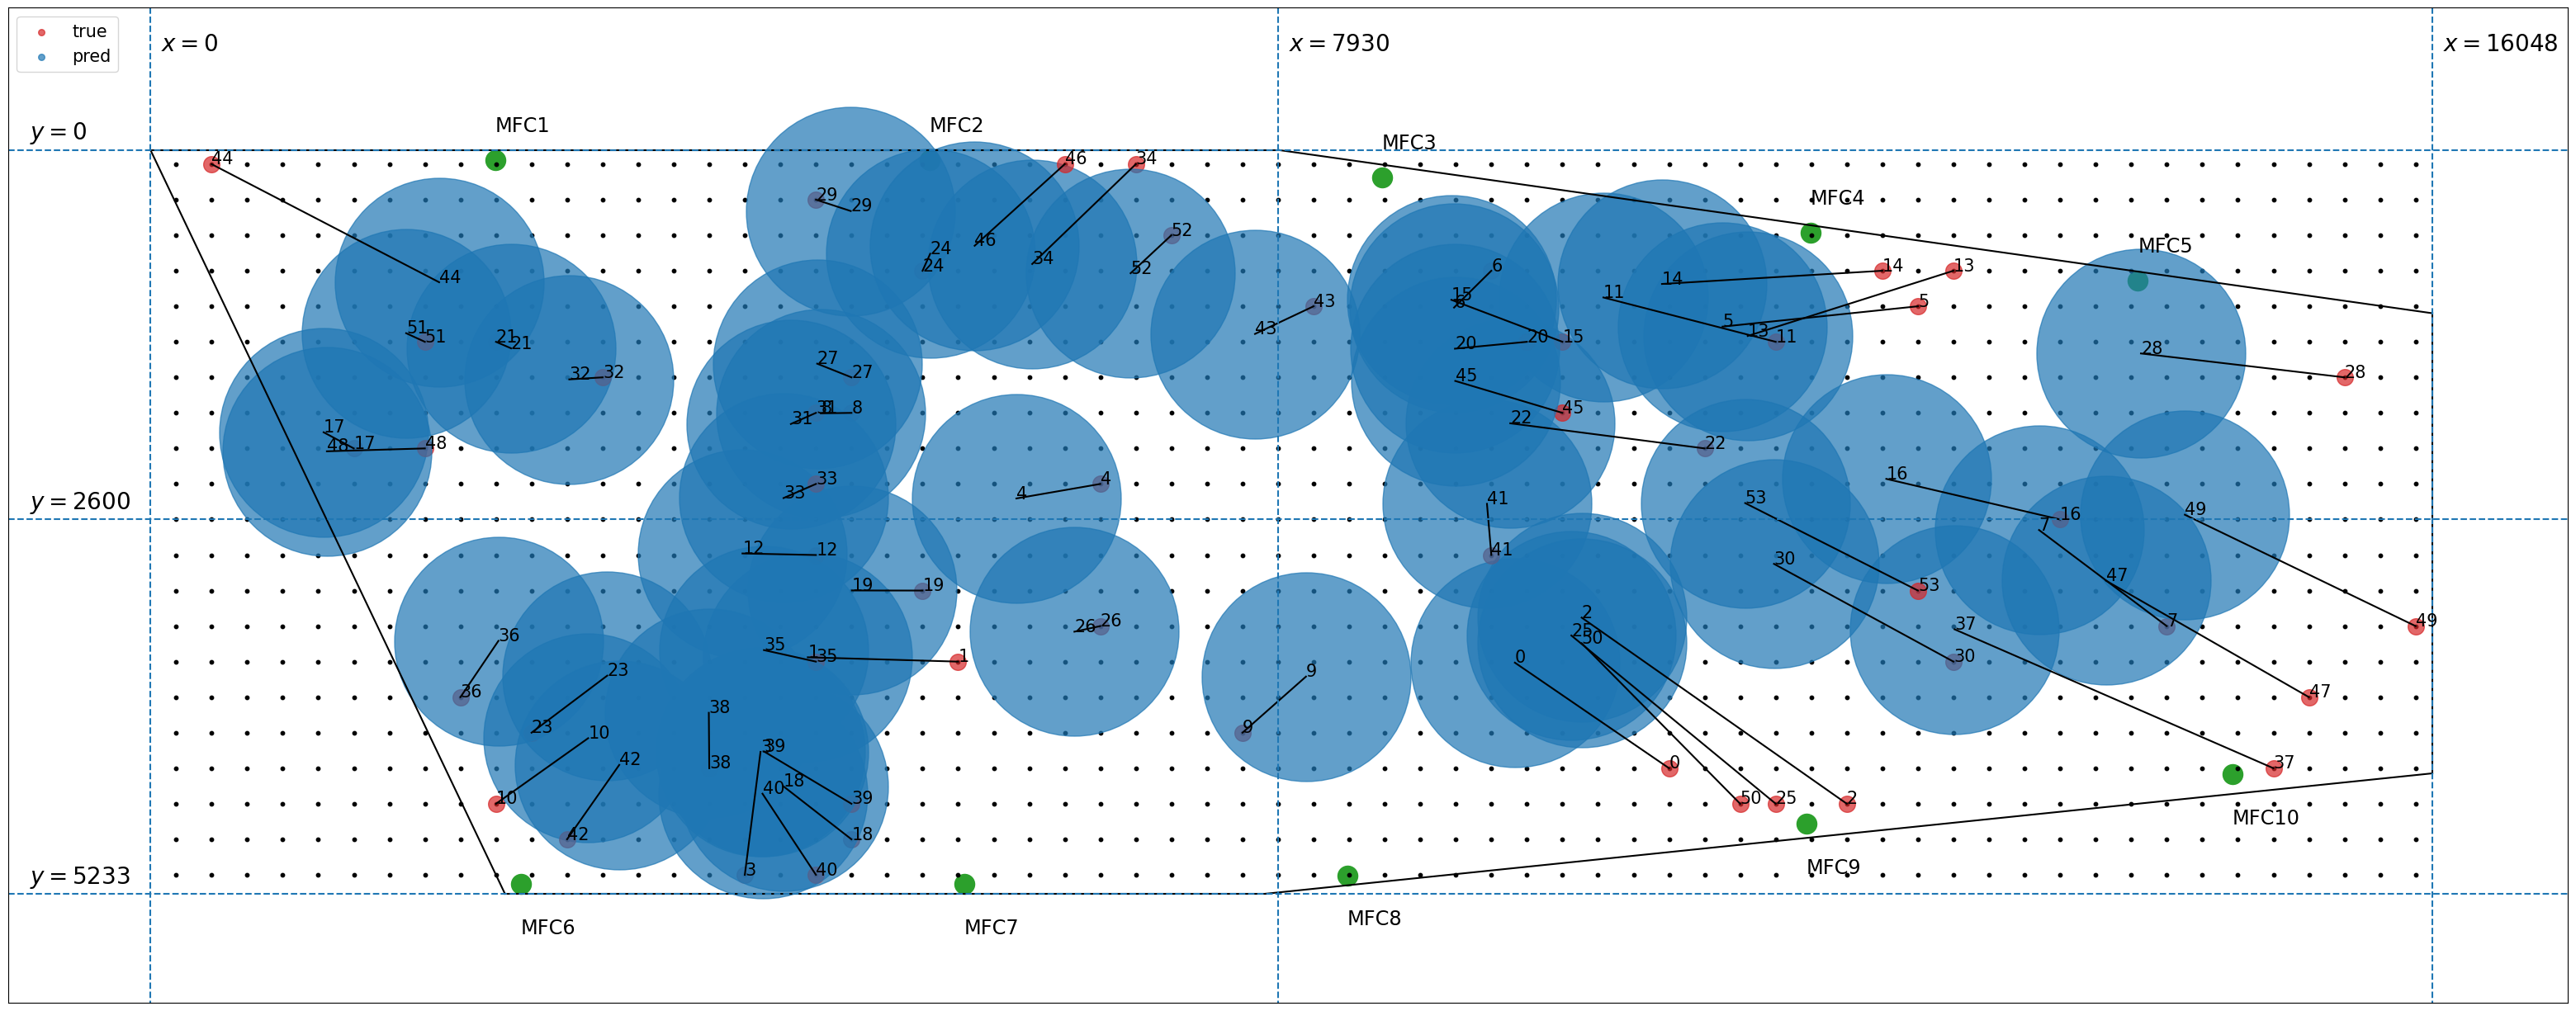

In [14]:
import matplotlib.pyplot as plt

x_range = np.arange(180, 16048, 250)
y_range = np.arange(100, 5233, 250)
X, Y = np.meshgrid(x_range, y_range)

def plot_test_pred_uncertainity(test, pred, radius):
    plt.figure(figsize=(40, 20))
    
    # plt.title(f'Sample Number {sample_number}', fontsize=20)
    
    # plot sensor positions
    sensors = np.array([[2426, 70], [5480, 70], [8661, 191], [11676, 584], [13976, 917], [2603, 5163], [5723, 5163], [8417, 5103], [11646, 4740], [14641, 4391]])
    for i in range(len(sensors)):
        plt.scatter(sensors[i, 0], sensors[i, 1], color='tab:green', s=300)
        if i < 5:
            plt.text(sensors[i, 0], sensors[i, 1] - 200, 'MFC'+str(i+1), fontsize='xx-large')
        else:
            plt.text(sensors[i, 0], sensors[i, 1] + 350, 'MFC'+str(i+1), fontsize='xx-large')

    # plot leakage positions
    plt.scatter(X, Y, color='black', s=10)
    # radius = radius.tolist()
    
    for i in range(len(test)):
        if i != len(test)-1:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200, alpha= 0.7)
            plt.scatter(pred[i][0], pred[i][1], s=radius, color='tab:blue', alpha= 0.7)
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)
        else:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200, label="true", alpha= 0.7)
            plt.scatter(pred[i][0], pred[i][1], s=radius, color='tab:blue', label="pred", alpha= 0.7)
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)

    # print(X.shape)
    legend = plt.legend(loc='upper right')
    # legend.legendHandles[0]._legmarker.set_markersize(15)
    # legend.legendHandles[0]._legmarker.set_alpha(1)
    # plot wing contour
    plot_wing_contour()

    # include grid coordinate system
    plt.hlines(0, -1000, 17000, linestyle='dashed')
    plt.hlines(2600, -1000, 17000, linestyle='dashed')
    plt.hlines(5233, -1000, 17000, linestyle='dashed')
    plt.vlines(0, -1000, 6000, linestyle='dashed')
    plt.vlines(7930, -1000, 6000, linestyle='dashed')
    plt.vlines(16048, -1000, 6000, linestyle='dashed')
    plt.text(-850, -75, '$y = 0$', fontsize=20)
    plt.text(-850, 2600-75, '$y = 2600$', fontsize=20)
    plt.text(-850, 5233-75, '$y = 5233$', fontsize=20)
    plt.text(75, -700, '$x=0$', fontsize=20)
    plt.text(7930+75, -700, '$x=7930$', fontsize=20)
    plt.text(16048+75, -700, '$x=16048$', fontsize=20)
    # plt.text(180, 5800, f'(x1, y1) = ({x1}, {y1}) = ({j1-31}, {-i1+10})', fontsize=20)
    plt.legend(loc="upper left")
    # invert y axis
    plt.gca().invert_yaxis()

    lgnd = plt.legend(loc="upper left", numpoints=2, fontsize=15)

    #change the marker size manually for both lines
    lgnd.legendHandles[0]._sizes = [30]
    lgnd.legendHandles[1]._sizes = [30]

    plt.savefig('./results/hypermodel_results.png')

    plt.show()

def plot_wing_contour():
    plt.plot([0, 7930], [0, 0], 'k')
    plt.plot([7930, 16048], [0, 1149], 'k')
    plt.plot([16048, 16048], [1149, 4386], 'k')
    plt.plot([16048, 7843], [4386, 5233], 'k')
    plt.plot([7843, 2493], [5233, 5233], 'k')
    plt.plot([2493, 0], [5233, 0], 'k')
    plt.xlim([-1000, 17000])
    plt.ylim([-1000, 6000])
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal')



plot_test_pred_uncertainity(y_test, pred_mean, radius)

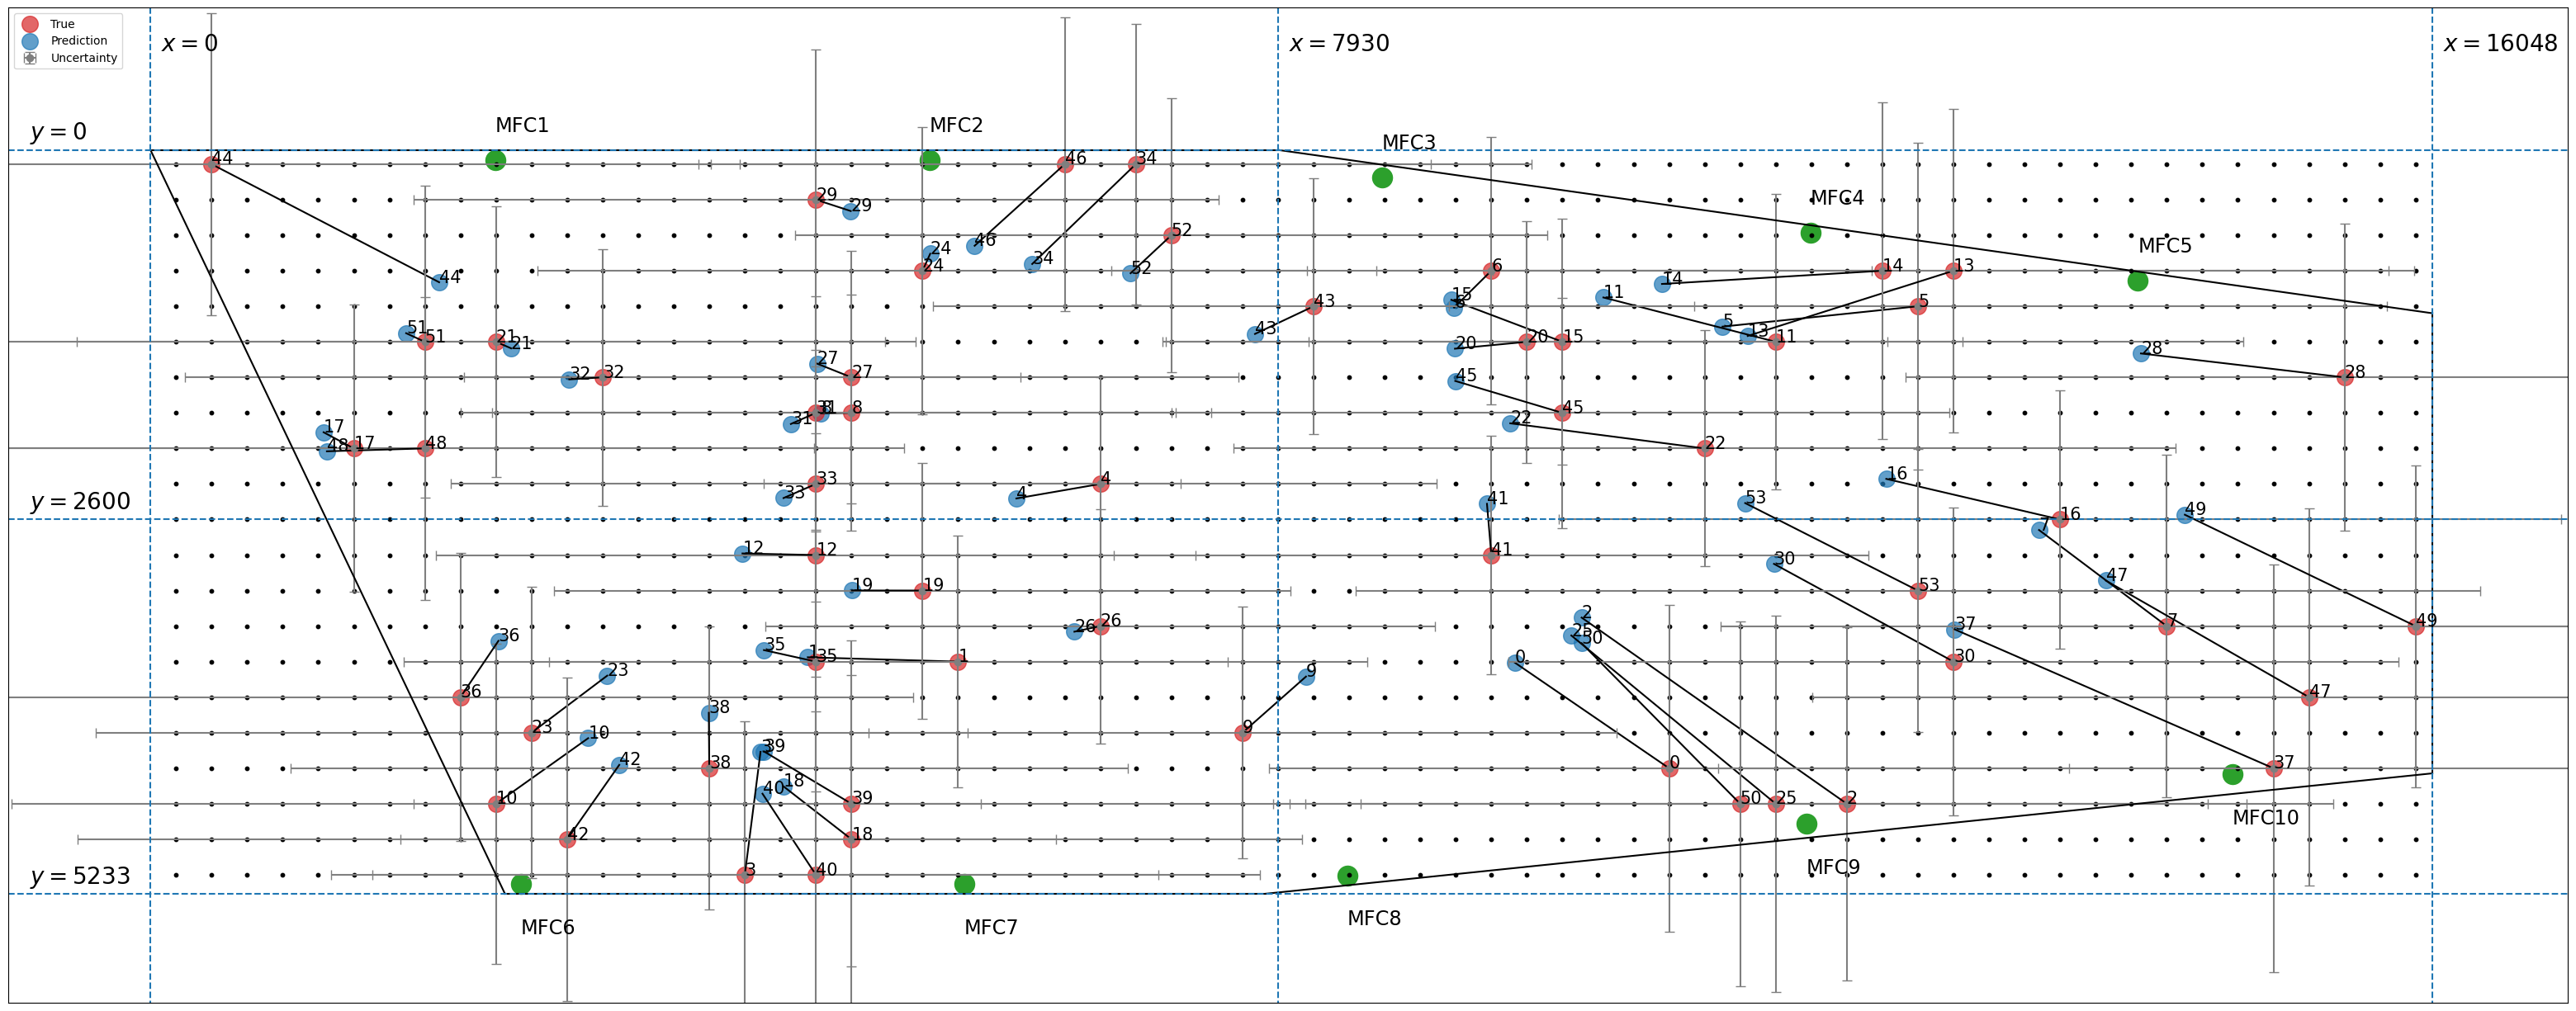

In [15]:
import matplotlib.pyplot as plt

x_range = np.arange(180, 16048, 250)
y_range = np.arange(100, 5233, 250)
X, Y = np.meshgrid(x_range, y_range)

def plot_test_pred_uncertainity(test, pred, radius, std):
    plt.figure(figsize=(40, 20))
    
    # plt.title(f'Sample Number {sample_number}', fontsize=20)
    
    # plot sensor positions
    sensors = np.array([[2426, 70], [5480, 70], [8661, 191], [11676, 584], [13976, 917], [2603, 5163], [5723, 5163], [8417, 5103], [11646, 4740], [14641, 4391]])
    for i in range(len(sensors)):
        plt.scatter(sensors[i, 0], sensors[i, 1], color='tab:green', s=300)
        if i < 5:
            plt.text(sensors[i, 0], sensors[i, 1] - 200, 'MFC'+str(i+1), fontsize='xx-large')
        else:
            plt.text(sensors[i, 0], sensors[i, 1] + 350, 'MFC'+str(i+1), fontsize='xx-large')

    # plot leakage positions
    plt.scatter(X, Y, color='black', s=10)
    radius = radius.tolist()
    
    for i in range(len(test)):
        if i != len(test)-1:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200, alpha= 0.7)
            plt.scatter(pred[i][0], pred[i][1], s=200, color='tab:blue', alpha= 0.7)
            plt.errorbar(test[i][0], test[i][1], xerr=pred_std[i][0], yerr=pred_std[i][1], fmt='o', color='tab:grey', capsize=4)
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)
        else:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200, label="True", alpha= 0.7)
            plt.scatter(pred[i][0], pred[i][1], s=200, color='tab:blue', label= "Prediction", alpha= 0.7)
            plt.errorbar(test[i][0], test[i][1], xerr=pred_std[i][0], yerr=pred_std[i][1], fmt='o', color='tab:grey', capsize=4, label='Uncertainty')
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)

    # print(X.shape)
    # legend = plt.legend(loc='upper right')
    # legend.legendHandles[0]._legmarker.set_markersize(15)
    # legend.legendHandles[0]._legmarker.set_alpha(1)
    # plot wing contour
    plot_wing_contour()

    # include grid coordinate system
    plt.hlines(0, -1000, 17000, linestyle='dashed')
    plt.hlines(2600, -1000, 17000, linestyle='dashed')
    plt.hlines(5233, -1000, 17000, linestyle='dashed')
    plt.vlines(0, -1000, 6000, linestyle='dashed')
    plt.vlines(7930, -1000, 6000, linestyle='dashed')
    plt.vlines(16048, -1000, 6000, linestyle='dashed')
    plt.text(-850, -75, '$y = 0$', fontsize=20)
    plt.text(-850, 2600-75, '$y = 2600$', fontsize=20)
    plt.text(-850, 5233-75, '$y = 5233$', fontsize=20)
    plt.text(75, -700, '$x=0$', fontsize=20)
    plt.text(7930+75, -700, '$x=7930$', fontsize=20)
    plt.text(16048+75, -700, '$x=16048$', fontsize=20)
    # plt.text(180, 5800, f'(x1, y1) = ({x1}, {y1}) = ({j1-31}, {-i1+10})', fontsize=20)
    plt.legend(loc="upper left")
    # invert y axis
    plt.gca().invert_yaxis()

    # lgnd = plt.legend(loc="upper left", numpoints=2, fontsize=15)

    #change the marker size manually for both lines
    # lgnd.legendHandles[0]._sizes = [30]
    # lgnd.legendHandles[1]._sizes = [30]

    plt.savefig('./results/hypermodel_results.png')

    plt.show()

def plot_wing_contour():
    plt.plot([0, 7930], [0, 0], 'k')
    plt.plot([7930, 16048], [0, 1149], 'k')
    plt.plot([16048, 16048], [1149, 4386], 'k')
    plt.plot([16048, 7843], [4386, 5233], 'k')
    plt.plot([7843, 2493], [5233, 5233], 'k')
    plt.plot([2493, 0], [5233, 0], 'k')
    plt.xlim([-1000, 17000])
    plt.ylim([-1000, 6000])
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal')


plot_test_pred_uncertainity(y_test, pred_mean, radius, pred_std)

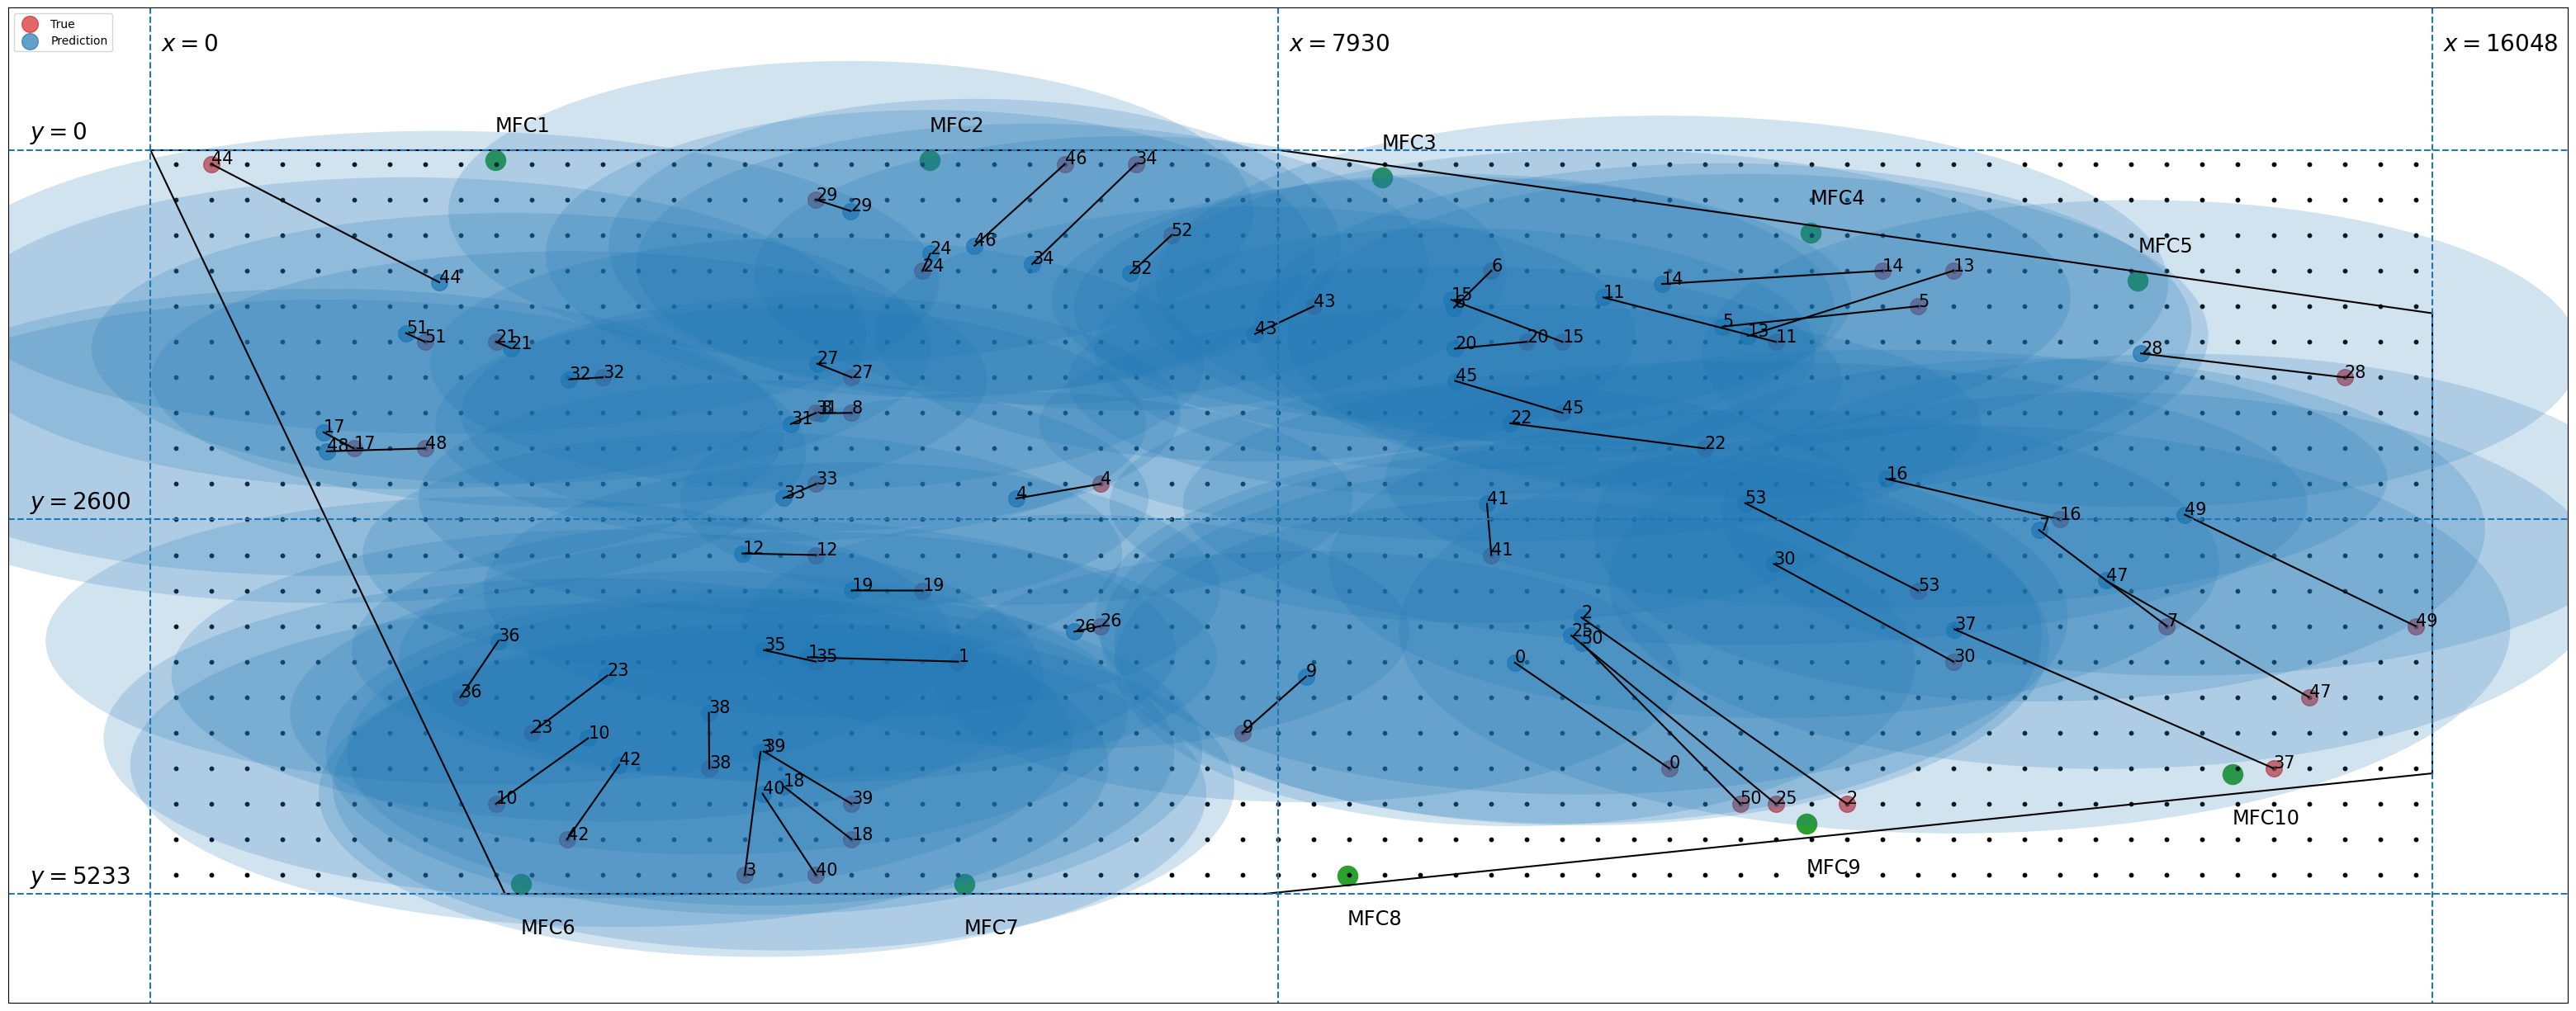

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

x_range = np.arange(180, 16048, 250)
y_range = np.arange(100, 5233, 250)
X, Y = np.meshgrid(x_range, y_range)

def plot_test_pred_uncertainity(test, pred, radius, std):
    plt.figure(figsize=(40, 20))
    
    # plt.title(f'Sample Number {sample_number}', fontsize=20)
    
    # plot sensor positions
    sensors = np.array([[2426, 70], [5480, 70], [8661, 191], [11676, 584], [13976, 917], [2603, 5163], [5723, 5163], [8417, 5103], [11646, 4740], [14641, 4391]])
    for i in range(len(sensors)):
        plt.scatter(sensors[i, 0], sensors[i, 1], color='tab:green', s=300)
        if i < 5:
            plt.text(sensors[i, 0], sensors[i, 1] - 200, 'MFC'+str(i+1), fontsize='xx-large')
        else:
            plt.text(sensors[i, 0], sensors[i, 1] + 350, 'MFC'+str(i+1), fontsize='xx-large')

    # plot leakage positions
    plt.scatter(X, Y, color='black', s=10)
    radius = radius.tolist()
    
    for i in range(len(test)):
        if i != len(test)-1:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200, alpha= 0.7)
            plt.scatter(pred[i][0], pred[i][1], s=200, color='tab:blue', alpha= 0.7)
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)
        else:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200, label="True", alpha= 0.7)
            plt.scatter(pred[i][0], pred[i][1], s=200, color='tab:blue', label= "Prediction", alpha= 0.7)
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)


    for i in range(len(pred)):
        mean_x, mean_y = pred[i][0], pred[i][1]
        sigma_x, sigma_y = std[i][0], std[i][1]

        # Plot ellipses representing uncertainty
        ellipse = patches.Ellipse((mean_x, mean_y), width=2*sigma_x, height=2*sigma_y, angle=0, alpha=0.2)
        plt.gca().add_patch(ellipse)
    plt.gca().set_aspect('equal')

    plot_wing_contour()

    # include grid coordinate system
    plt.hlines(0, -1000, 17000, linestyle='dashed')
    plt.hlines(2600, -1000, 17000, linestyle='dashed')
    plt.hlines(5233, -1000, 17000, linestyle='dashed')
    plt.vlines(0, -1000, 6000, linestyle='dashed')
    plt.vlines(7930, -1000, 6000, linestyle='dashed')
    plt.vlines(16048, -1000, 6000, linestyle='dashed')
    plt.text(-850, -75, '$y = 0$', fontsize=20)
    plt.text(-850, 2600-75, '$y = 2600$', fontsize=20)
    plt.text(-850, 5233-75, '$y = 5233$', fontsize=20)
    plt.text(75, -700, '$x=0$', fontsize=20)
    plt.text(7930+75, -700, '$x=7930$', fontsize=20)
    plt.text(16048+75, -700, '$x=16048$', fontsize=20)
    # plt.text(180, 5800, f'(x1, y1) = ({x1}, {y1}) = ({j1-31}, {-i1+10})', fontsize=20)
    plt.legend(loc="upper left")
    # invert y axis
    plt.gca().invert_yaxis()

    # lgnd = plt.legend(loc="upper left", numpoints=2, fontsize=15)

    #change the marker size manually for both lines
    # lgnd.legendHandles[0]._sizes = [30]
    # lgnd.legendHandles[1]._sizes = [30]

    plt.savefig('./results/hypermodel_results.png')

    plt.show()

def plot_wing_contour():
    plt.plot([0, 7930], [0, 0], 'k')
    plt.plot([7930, 16048], [0, 1149], 'k')
    plt.plot([16048, 16048], [1149, 4386], 'k')
    plt.plot([16048, 7843], [4386, 5233], 'k')
    plt.plot([7843, 2493], [5233, 5233], 'k')
    plt.plot([2493, 0], [5233, 0], 'k')
    plt.xlim([-1000, 17000])
    plt.ylim([-1000, 6000])
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal')

plot_test_pred_uncertainity(y_test, pred_mean, radius, pred_std)